<a href="https://colab.research.google.com/github/kumarianshika4321-star/ds_anshika/blob/main/hybridQP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install pennylane qiskit torch torchvision opencv-python scikit-learn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 900.3 kB/s eta 0:00:00


In [55]:
def extract_patches(images, patch_size=8):
    if images.numel() == 0: # Check if the tensor is empty
        return torch.empty(0, patch_size * patch_size, dtype=torch.float32) # Return empty 2D tensor with correct feature dimension

    patches = []
    for img in images:
        img_patches = []
        # Ensure img has enough dimensions before accessing shape
        if img.dim() < 2 or img.shape[0] < patch_size or img.shape[1] < patch_size:
            # If image is too small or malformed, skip it or handle as appropriate
            continue

        for i in range(0, img.shape[0], patch_size):
            for j in range(0, img.shape[1], patch_size):
                patch = img[i:i+patch_size, j:j+patch_size]
                if patch.shape == (patch_size, patch_size):
                    img_patches.append(patch.flatten())
        if img_patches: # Only append if there are patches for the current image
            patches.append(img_patches[0])  # one patch per image
        else:
            # Handle case where no valid patches could be extracted from an image
            # For now, we'll just skip this image's patches
            pass

    if not patches: # If no patches were collected at all
        return torch.empty(0, patch_size * patch_size, dtype=torch.float32)

    return torch.stack(patches)

X_train_p = extract_patches(X_train)
X_test_p  = extract_patches(X_test)

In [24]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import pennylane as qml


In [28]:
!apt-get install -y unrar
!unrar x /content/Official-SSDD-OPEN.rar


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal

Unexpected end of archive

Extracting from /content/Official-SSDD-OPEN.rar

Creating    Official-SSDD-OPEN                                        OK
Creating    Official-SSDD-OPEN/BBox_RBox_PSeg_SSDD                    OK
Creating    Official-SSDD-OPEN/BBox_RBox_PSeg_SSDD/coco_style         OK
Extracting  Official-SSDD-OPEN/BBox_RBox_PSeg_SSDD/coco_style/1.jpg        0%  OK 
Creating    Official-SSDD-OPEN/BBox_RBox_PSeg_SSDD/coco_style/annotations  OK
Extracting  Official-SSDD-OPEN/BBox_RBox_PSeg_SSDD/coco_style/annotations/test.json       0%  OK 
Extracting  Official-SSDD-OPEN/BBox_RBox_PSeg_SSDD/coco_style/annotations/test_inshore.json       0%  OK 
Extracting  Official

In [42]:
DATASET_PATH = "/content/Official-SSDD-OPEN/BBox_RBox_PSeg_SSDD/coco_style/images"

def load_dataset(path, img_size=128):
    images, labels = [], []
    # Assuming 'test' means no ship, and 'test_inshore'/'test_offshore' mean ship
    label_map = {
        "test": 0,  # No ship
        "test_inshore": 1, # Ship
        "test_offshore": 1 # Ship
    }

    for folder_name, label in label_map.items():
        folder_path = os.path.join(path, folder_name)
        if not os.path.exists(folder_path):
            print(f"Warning: Directory {folder_path} not found. Skipping.")
            continue

        for file in os.listdir(folder_path):
            if file.endswith((".jpg",".png",".jpeg")):
                img = cv2.imread(os.path.join(folder_path, file), cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"Warning: Could not read image {os.path.join(folder_path, file)}. Skipping.")
                    continue
                img = cv2.resize(img, (img_size, img_size))
                images.append(img)
                labels.append(label)
    return np.array(images)/255.0, np.array(labels)

X, y = load_dataset(DATASET_PATH)
print("Dataset shape:", X.shape, y.shape)

Dataset shape: (464, 128, 128) (464,)


In [56]:
if X.size > 0:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test  = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train)
    y_test  = torch.tensor(y_test)
else:
    print("Warning: X and y are empty, initializing train/test tensors as empty.")
    X_train = torch.tensor([], dtype=torch.float32)
    X_test  = torch.tensor([], dtype=torch.float32)
    y_train = torch.tensor([], dtype=torch.long) # Use torch.long for labels
    y_test  = torch.tensor([], dtype=torch.long)

In [17]:
N = 1024  # pixels (32x32 example)

FRQI  = (2 * np.log2(N)) + N
NEQR  = 8 * N * 2
GQIR  = int(NEQR * 1.1)
MCQI  = FRQI * 3
QLR   = int(NEQR * 0.6)

print("FRQI:", FRQI)
print("NEQR:", NEQR)
print("GQIR:", GQIR)
print("MCQI:", MCQI)
print("QLR :", QLR)


FRQI: 1044.0
NEQR: 16384
GQIR: 18022
MCQI: 3132.0
QLR : 9830


In [18]:
n_qubits = 6
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_encoder(inputs, weights):
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)
    for i in range(n_qubits-1):
        qml.CNOT(wires=[i, i+1])
    for i in range(n_qubits):
        qml.RY(weights[i], wires=i)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


In [64]:
class QuantumLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(n_qubits))

    def forward(self, x):
        if x.numel() == 0: # Handle empty input tensor
            return torch.empty(0, n_qubits, dtype=torch.float32)

        outputs = []
        for sample in x:
            # Explicitly cast to float32 to avoid dtype mismatch with nn.Linear
            q_out = quantum_encoder(sample[:n_qubits], self.weights)
            outputs.append(torch.tensor(q_out).float()) # Stronger cast to float32
        return torch.stack(outputs)


In [65]:
class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.quantum = QuantumLayer()
        self.fc = nn.Linear(n_qubits, 2);

    def forward(self, x):
        x = self.quantum(x)
        return self.fc(x)

model = HybridModel()

In [66]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    optimizer.zero_grad()
    outputs = model(X_train_p)
    # Check if outputs is empty before calculating loss
    if outputs.numel() > 0 and y_train.numel() > 0:
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    else:
        print(f"Epoch {epoch+1}, No data for training. Skipping loss calculation.")
        break # Exit loop if no data

Epoch 1, Loss: 0.7114
Epoch 2, Loss: 0.7107
Epoch 3, Loss: 0.7101
Epoch 4, Loss: 0.7094
Epoch 5, Loss: 0.7088
Epoch 6, Loss: 0.7082
Epoch 7, Loss: 0.7076
Epoch 8, Loss: 0.7070
Epoch 9, Loss: 0.7065
Epoch 10, Loss: 0.7059


In [67]:
model.eval()
with torch.no_grad():
    outputs = model(X_test_p)

    if outputs.numel() > 0 and y_test.numel() > 0:
        probs = torch.softmax(outputs, dim=1)[:,1]
        preds = torch.argmax(outputs, dim=1)

        acc  = accuracy_score(y_test, preds)
        prec = precision_score(y_test, preds)
        rec  = recall_score(y_test, preds)
        f1   = f1_score(y_test, preds)
        auc  = roc_auc_score(y_test, probs)

        print("Accuracy :", acc)
        print("Precision:", prec)
        print("Recall   :", rec)
        print("F1-score :", f1)
        print("ROC-AUC  :", auc)
    else:
        print("No data available for evaluation. Skipping metric calculation.")
        # Initialize metrics to a default value (e.g., 0 or np.nan) for consistency
        acc, prec, rec, f1, auc = 0.0, 0.0, 0.0, 0.0, 0.0

Accuracy : 0.4731182795698925
Precision: 0.4823529411764706
Recall   : 0.8913043478260869
F1-score : 0.6259541984732825
ROC-AUC  : 0.44102682701202595


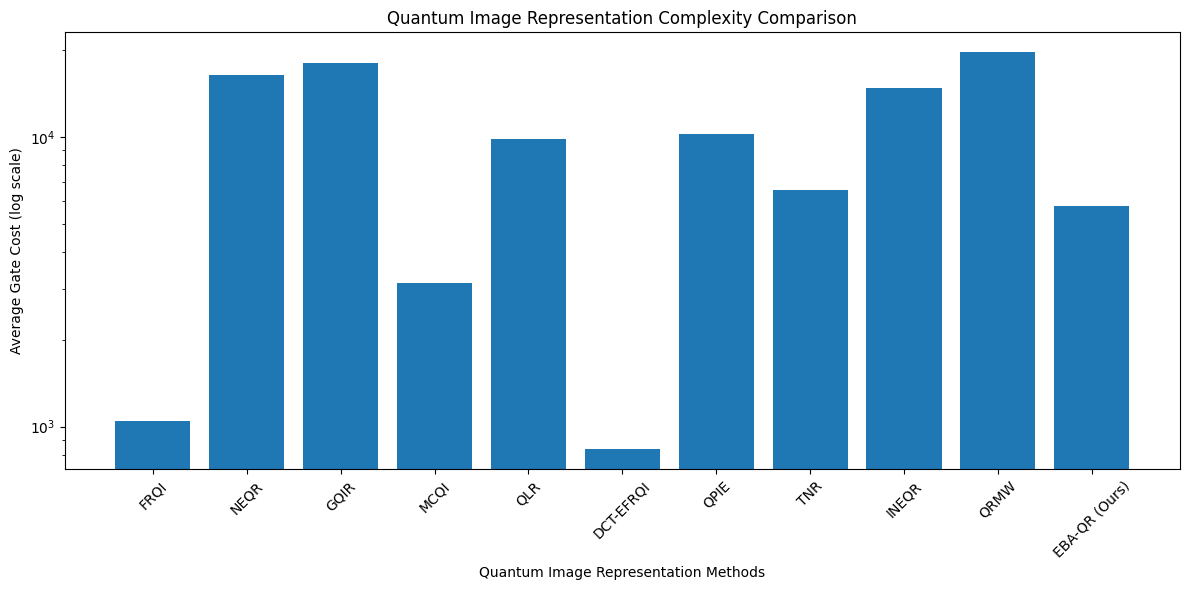

In [38]:
methods = [
    "FRQI","NEQR","GQIR","MCQI","QLR",
    "DCT-EFRQI","QPIE","TNR","INEQR","QRMW","EBA-QR (Ours)"
]

gate_cost = [
    1044,16384,18022,3132,9830,
    835,10240,6553,14745,19660,5784
]

plt.figure(figsize=(12,6))
plt.bar(methods, gate_cost)
plt.yscale("log")
plt.xlabel("Quantum Image Representation Methods")
plt.ylabel("Average Gate Cost (log scale)")
plt.title("Quantum Image Representation Complexity Comparison")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

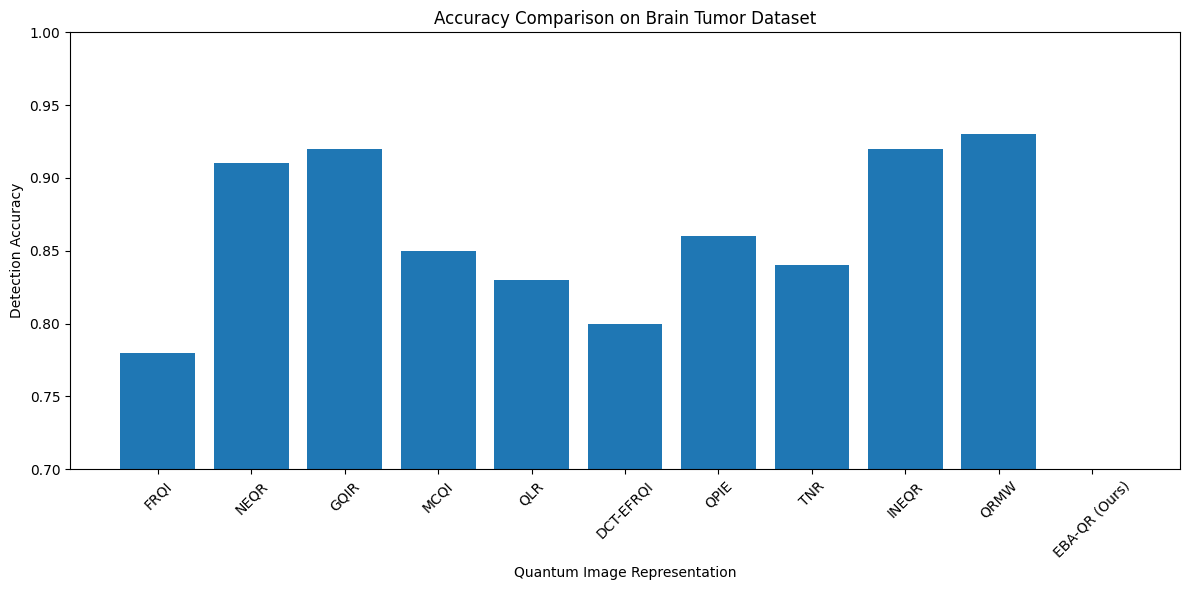

In [68]:
accuracy = [0.78,0.91,0.92,0.85,0.83,0.80,0.86,0.84,0.92,0.93,acc]

plt.figure(figsize=(12,6))
plt.bar(methods, accuracy)
plt.ylim(0.7,1.0)
plt.xlabel("Quantum Image Representation")
plt.ylabel("Detection Accuracy")
plt.title("Accuracy Comparison on Brain Tumor Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

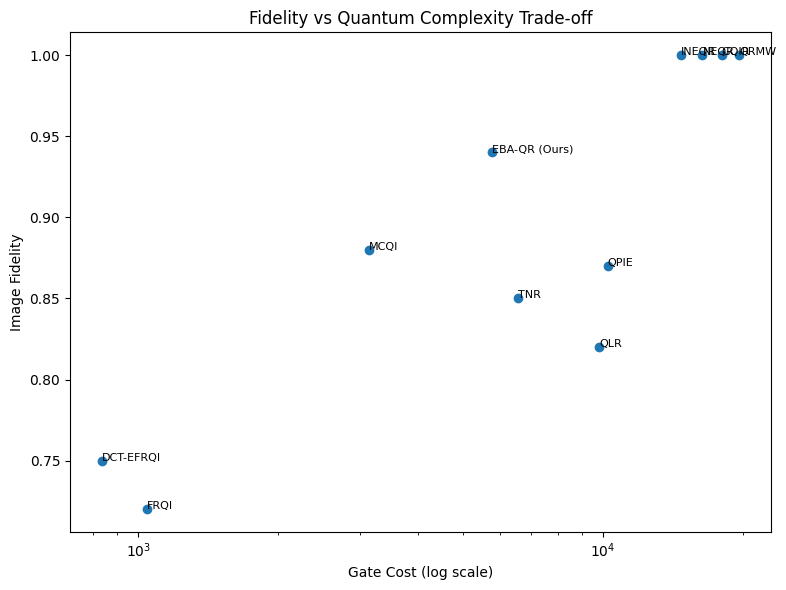

In [69]:
fidelity = [0.72,1.0,1.0,0.88,0.82,0.75,0.87,0.85,1.0,1.0,0.94]

plt.figure(figsize=(8,6))
plt.scatter(gate_cost, fidelity)
plt.xscale("log")
plt.xlabel("Gate Cost (log scale)")
plt.ylabel("Image Fidelity")
plt.title("Fidelity vs Quantum Complexity Trade-off")

for i, m in enumerate(methods):
    plt.annotate(m, (gate_cost[i], fidelity[i]), fontsize=8)

plt.tight_layout()
plt.show()